### Import packages and set up matplotlib plotting defaults

In [1]:
#import packages
import xarray as xr

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

import cartopy  
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

import scipy.stats

import numpy as np

import cmocean

#Matplotlib plotting configuration
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
font = {'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

#set widths to use for setting figure sizes
half_width=3.5 #width of 1/2 page figure
full_width=7 #with of full page figure

#create figures directory if doesn't exist already
import os
os.makedirs('figures', exist_ok=True) 

### Load datasets

In [2]:
#Load bathymetry data from GEBCO 2022 
#https://www.gebco.net/data_and_products/gridded_bathymetry_data/gebco_2022/
bathym=xr.open_dataset("datasets/gebco_2022_n37.4_s34.35_w-123.4_e-120.3.nc")

#GlobColour Chl-a dataset OCEANCOLOUR_GLO_BGC_L4_MY_009_104
#load data from copernicus "Global Ocean Colour (Copernicus-GlobColour), Bio-Geo-Chemical, 
#L4 (monthly and interpolated) from Satellite Observations (1997-ongoing)"
#DOI: https://doi.org/10.48670/moi-00281
#dataset: cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M_1681345152384
CHL = xr.open_dataset("datasets/cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M_1681345152384.nc")
CHL=CHL.rename({'lat':'latitude','lon':'longitude'})
CHL_time= CHL.sel(latitude=slice(37.4,34.35), longitude=slice(-123.4,-120.3),time=slice('1999-01-01', '2021-12-31'))
total_meanchl=CHL_time.mean('time')
yr_meanchl=CHL_time.groupby('time.year').mean('time')

#water year mean discharge Salinas River (starts Oct 1 year before goes until sept 30 of year)
salinas_wtryr=pd.read_csv('datasets/salinas_wtryr_discharge.csv')
salinas_wtryr=salinas_wtryr.loc[(salinas_wtryr['wtr_yr'] > 1998) & (salinas_wtryr['wtr_yr'] < 2022)]
salinas_mean = xr.DataArray(salinas_wtryr.mean_discharge, dims='year', coords={'year':salinas_wtryr.wtr_yr})

#Granite Canyon Sea Surface temperature
SST_GC=pd.read_csv('datasets/GC_SST.csv')
SST_GC=SST_GC.loc[(SST_GC['YEAR'] > 1998) & (SST_GC['YEAR'] < 2022)]
SST_GC['time'] = pd.to_datetime(dict(year=SST_GC.YEAR, month=SST_GC.MONTH, day=SST_GC.DAY))
SST_GC_monthly=SST_GC.resample('M', on='time').mean()
SST_GC_monthly['time']=SST_GC_monthly.index
SST_GC_annual=SST_GC_monthly.resample('Y',on='time').mean()
SST_GC_upseason=SST_GC_monthly.loc[SST_GC_monthly['time'].dt.month.between(4,8)].resample('Y',on='time').mean()

#BEUTI
beuti_monthly=pd.read_csv('datasets/BEUTI_monthly.csv')
beuti_monthly['mean35_37N']=beuti_monthly[['35N','36N','37N']].mean(axis=1)
beuti_monthly=beuti_monthly.loc[(beuti_monthly['year'] > 1997) & (beuti_monthly['year'] < 2022)]
beuti_monthly['time']=pd.to_datetime(pd.DataFrame({'day': 1,'month': beuti_monthly.month,'year': beuti_monthly.year}))
beuti_monthly=beuti_monthly.set_index('time')
beuti_ds=beuti_monthly.to_xarray()
beuti_mean=beuti_ds.mean35_37N.groupby('time.year').mean('time')
beuti_max=beuti_ds.mean35_37N.groupby('time.year').max('time')
beuti_mean=beuti_mean.loc[(beuti_mean['year'] > 1998) & (beuti_mean['year'] < 2022)]
beuti_max=beuti_max.loc[(beuti_max['year'] > 1998) & (beuti_max['year'] < 2022)]

### Figure 1

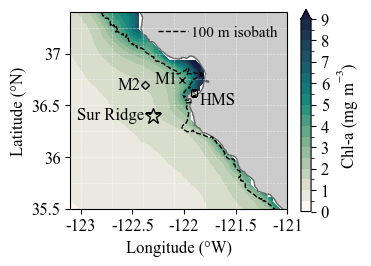

In [3]:
#plot mean satellite Chl-a from 1999-2021 from copernicus satellite data

# initialize cartopy plot
proj = ccrs.PlateCarree()
fig=plt.figure(figsize=(half_width,half_width*(3/4)))
ax = plt.axes(projection=proj)

# plot 100 m depth contour
bath=bathym.elevation.plot.contour(subplot_kws=dict(projection=proj),transform=ccrs.PlateCarree(),
                              colors='k',linewidths=1,linestyles='--',levels=[-100],zorder=20)

#clean up 100m depth contour by removing any short segments
for level in bath.collections:
    for kp,path in reversed(list(enumerate(level.get_paths()))):
        verts = path.vertices # (N,2)-shape array of contour line coordinates
        diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
        if diameter<1: # threshold to be refined for your actual dimensions!
            del(level.get_paths()[kp])  # no remove() for Path objects:(

#select chl-a  contour levels
levels=np.arange(0,9.01,0.5)

#select colormap for plotting chl-a
colormap=cmocean.cm.tempo

# plot chl-a in filled contour plot
total_meanchl.CHL.plot.contourf(subplot_kws=dict(projection=proj),
                                transform=ccrs.PlateCarree(),cmap=colormap,levels=levels,
                                cbar_kwargs={'label':'Chl-a $\mathregular{(mg\ m^{-3})}$', 'format':ticker.FormatStrFormatter('%g')},
                                alpha=1,zorder=-1)

# Add study sites and text annotations
plt.plot(-122.3,36.4,color='None',markeredgecolor='k',marker='*',markersize=12,transform=ccrs.PlateCarree(),zorder=10)
plt.text(-122.39,36.4,'Sur Ridge',ha='right',va='center',zorder=10)

plt.plot(-122.378,36.697,color='None',markeredgecolor='k',marker='D',markersize=4,transform=ccrs.PlateCarree(),zorder=10)
plt.text(-122.42,36.697,'M2',ha='right',va='center',zorder=10)

plt.plot(-122.022,36.747,color='None',markeredgecolor='k',marker='x',markersize=4,transform=ccrs.PlateCarree(),zorder=10)
plt.text(-122.062,36.747,'M1',ha='right',va='center',zorder=10)

plt.plot(-121.9041,36.62,color='None',markeredgecolor='k',marker='s',markersize=4,transform=ccrs.PlateCarree(),zorder=10)
plt.text(-121.85,36.55,'HMS',ha='left',va='center',zorder=10)

#add land feature
coast_10m = cfeature.NaturalEarthFeature("physical", "coastline", "10m",
                                         edgecolor='0.4', facecolor="0.8",
                                         alpha=1,zorder=0)
ax.add_feature(coast_10m)

#configure gridlines and ticks and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, 
                  linewidth=.5, color='w', alpha=0.5, linestyle='--')

gl.top_labels = False
gl.right_labels = False

xt=[-123,-122.5,-122,-121.5,-121]
yt=[34.5,35,35.5,36,36.5,37]

ax.set_xticks(xt, crs=ccrs.PlateCarree())
ax.set_yticks(yt, crs=ccrs.PlateCarree())

ax.set_xticklabels(map(str,xt))
ax.set_yticklabels(map(str,yt))

ax.tick_params(color='k', labelcolor='k')

#add axis labels
ax.set_ylabel('Latitude (°N)',color='k')
ax.set_xlabel('Longitude (°W)',color='k')

#set plot extent
ax.set_extent([-123.1, -121, 35.5, 37.4],crs=ccrs.PlateCarree())

#create fake dashed line to facilitate isobath legend creation
ax.plot([0,0],[2,2],transform=ccrs.PlateCarree(),color='k',linewidth=1,linestyle='--',
        zorder=-100,label='100 m isobath')

ax.legend(facecolor='None',frameon=False,fontsize=11,loc='right',bbox_to_anchor=(1.02,.9),handletextpad=.2)

plt.savefig('figures/FIG1.pdf', dpi=1000,bbox_inches='tight')
plt.show()
plt.close()

### Computing correlations between Chl-a and other variables of interest (BEUTI, river discharge, SST) at each location in domain of interest

In [4]:
#make empty xarray data arrays of correct shape that we will fill
cor_map_meanchl_salinasmean = yr_meanchl.CHL.isel(year=0) * 0.
cor_map_meanchl_GCupseasonSST = yr_meanchl.CHL.isel(year=0) * 0.
cor_map_meanchl_beutimean = yr_meanchl.CHL.isel(year=0) * 0.

sig_map_meanchl_salinasmean = yr_meanchl.CHL.isel(year=0) * 0.
sig_map_meanchl_GCupseasonSST = yr_meanchl.CHL.isel(year=0) * 0.
sig_map_meanchl_beutimean = yr_meanchl.CHL.isel(year=0) * 0. 

# loop over lats and lons, calculating spearman correlations and p-values at each location
for j in np.arange(len(yr_meanchl.latitude)):
    for i in np.arange(len(yr_meanchl.longitude)):
        cor_map_meanchl_salinasmean.values[j, i] = scipy.stats.spearmanr(yr_meanchl.CHL.values[:, j, i], salinas_mean.values)[0]
        sig_map_meanchl_salinasmean.values[j, i] = scipy.stats.spearmanr(yr_meanchl.CHL.values[:, j, i], salinas_mean.values)[1]
       
        cor_map_meanchl_GCupseasonSST.values[j, i] = scipy.stats.spearmanr(yr_meanchl.CHL.values[:, j, i], SST_GC_upseason.SST)[0]
        sig_map_meanchl_GCupseasonSST.values[j, i] = scipy.stats.spearmanr(yr_meanchl.CHL.values[:, j, i], SST_GC_upseason.SST)[1]
                          
        cor_map_meanchl_beutimean.values[j, i] = scipy.stats.spearmanr(yr_meanchl.CHL.values[:, j, i], beuti_mean.values)[0] 
        sig_map_meanchl_beutimean.values[j, i] = scipy.stats.spearmanr(yr_meanchl.CHL.values[:, j, i], beuti_mean.values)[1] 

### Figure 9

C:\Users\gmpug\.conda\envs\pyleo_env\lib\site-packages\cartopy\mpl\geoaxes.py:1604: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)


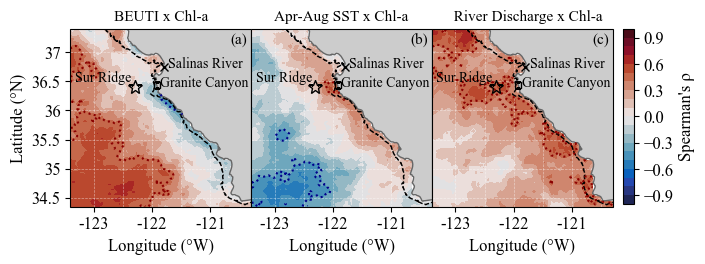

In [5]:
#initialize plot with 3 subplots
proj = ccrs.PlateCarree()
fig, axs = plt.subplots(nrows=1,ncols=3,sharey=True,
                        subplot_kw={'projection': proj},
                        figsize=(full_width,2.5))

#select spearman correlation data to plot in each subplot
corr_list=[cor_map_meanchl_beutimean,cor_map_meanchl_GCupseasonSST,cor_map_meanchl_salinasmean]
sig_list=[sig_map_meanchl_beutimean,sig_map_meanchl_GCupseasonSST,sig_map_meanchl_salinasmean]

# specify titles for each subplot
title_list=['BEUTI x Chl-a','Apr-Aug SST x Chl-a','   River Discharge x Chl-a']
label_list=['(a)','(b)','(c)']

# specify what lat and lon values you want ticks at
xt=[-123,-122,-121]
yt=[34.5,35,35.5,36,36.5,37]

# iterate through each subplot, plotting various things and configuring
for i in [0,1,2]:
    
    #plot 100 m isobath and clean up to remove short segments
    bath=axs[i].contour(bathym.lon,bathym.lat,bathym.elevation,transform=ccrs.PlateCarree(),
                    colors='k',linewidths=1,linestyles='--',levels=[-100],zorder=2)

    for level in bath.collections:
        for kp,path in reversed(list(enumerate(level.get_paths()))):
            verts = path.vertices # (N,2)-shape array of contour line coordinates
            diameter = np.max(verts.max(axis=0) - verts.min(axis=0))
            if diameter<1: # threshold to be refined for your actual dimensions!
                del(level.get_paths()[kp])  # no remove() for Path objects:(

    #plot spearman correlations between chl-a and var of interest
    contour=axs[i].contourf(corr_list[i].longitude,corr_list[i].latitude,corr_list[i].values,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance,levels=np.arange(-1,1.01,.1),zorder=-10)

    #plot contours around areas with statistically significant correlations
    pos_sig_sel=sig_list[i].where(corr_list[i].values>0) #select p-values where rho > 0
    neg_sig_sel=sig_list[i].where(corr_list[i].values<0) #select p-values where rho < 0
    axs[i].contour(pos_sig_sel.longitude,pos_sig_sel.latitude,pos_sig_sel.values,transform=ccrs.PlateCarree(),
                   colors='darkred',linestyles='dotted',linewidths=1.5,levels=[0.05])
    axs[i].contour(neg_sig_sel.longitude,neg_sig_sel.latitude,neg_sig_sel.values,transform=ccrs.PlateCarree(),
                   colors='darkblue',linestyles='dotted',linewidths=1.5,levels=[0.05])

    # add locations of interest and corresponding labels
    axs[i].plot(-122.3,36.4,color='None',markeredgecolor='k',marker='*',markersize=10,lw=1,transform=ccrs.PlateCarree())
    axs[i].text(-122.3-.06,36.4+.04,'Sur Ridge',ha='right',va='bottom',fontsize=10)

    axs[i].plot(-121.92,36.44,color='None',markeredgecolor='k',marker='s',markersize=4,lw=1,transform=ccrs.PlateCarree(),zorder=10)
    axs[i].text(-121.92+.06,36.44+.04,'Granite Canyon',ha='left',va='center',zorder=10,fontsize=10)

    axs[i].plot(-121.80,36.75,color='k',marker='x',lw=1,transform=ccrs.PlateCarree())
    axs[i].text(-121.80+.08,36.75+.05,'Salinas River',ha='left',va='center',fontsize=10)

    #add land to map
    coast_10m = cfeature.NaturalEarthFeature(
        "physical", "land", "10m", edgecolor="0.4", facecolor="0.8",zorder=1)
    axs[i].add_feature(coast_10m)

    #set subplot title and label
    axs[i].set_title(title_list[i],fontsize=11)
    axs[i].text(.98,.98,label_list[i],ha='right',va='top',fontsize=11,color='k',transform=axs[i].transAxes,
               bbox=dict(facecolor='None', alpha=0.4, lw=0))
    
    #set subplot extent
    axs[i].set_extent([-123.4, -120.3, 34.35, 37.4],crs=ccrs.PlateCarree())

    # configure ticks
    axs[i].set_xticks(xt, crs=ccrs.PlateCarree())
    axs[i].set_xticklabels(map(str,xt))
    if i == 0:
        axs[i].set_yticks(yt, crs=ccrs.PlateCarree())
        axs[i].set_yticklabels(map(str,yt))
        axs[i].set_ylabel('Latitude (°N)')
    
    #label x-axis
    axs[i].set_xlabel('Longitude (°W)')

    #configure gridlines
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=.5, color='w', alpha=0.5, linestyle='--',zorder=-5)
    gl.top_labels = False
    gl.right_labels = False

# Add a colorbar axis and draw the colorbar
cbar_ax = fig.add_axes([.915,.15, 0.015, .7])
fig.colorbar(contour, cax=cbar_ax,orientation='vertical',label="Spearman's ρ")

# adjust subplot spacing
fig.subplots_adjust(wspace=0)

#save, display and close figure
plt.savefig('figures/FIG9.pdf', dpi=1000,bbox_inches='tight')

plt.show()
plt.close()